# Supervised Learning

In machine learning, we use *data* to create and train *models* which can then be used to make *predictions*. For supervised learning we need *labeled* data. This means we need to know not only the data values, but also what those values represent. 

For example, let's say we want to train a model to label images using supervised learning. In this case, the data on which we train our model would need to be something like:

![labeled imgs](https://anima-kit.github.io/ai-notebooks/assets/labeled-imgs.png)

This sort of problem would be a *classification* problem. We want the model to be able to predict different categories (e.g. Dog, Cat, Elephant). Another common type of problem is a *regression* problem. This is where we want our model to be able to predict some continuous variable, like a price, a body metric, or a time. While other supervised learning categories exist, many problems can be seen as either one of these two: a *classification* or a *regression* problem. 

In this tutorial, we're going to start with regression in a very simple form. We'll get to see how to solve a real-life problem, predicting how much energy will be consumed based on various factors, by going through the code and math, step-by-step.

As we progress through the tutorials, we'll see how to improve our regression model through various methods. Then, we'll move onto classification problems, in which we can utilize many of the methods that we learned for model improvements. 

# Linear Regression Setup

One of the simplest models to learn and work with is the *linear regression* model. In this tutorial, we're going to see how this model works and how to train it on example data through a step-by-step guide with interactive code so we can see exactly what's happening.

The data we're going to use is a [Kaggle dataset](https://www.kaggle.com/datasets) for [daily energy consumption](https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction) which has data like:

| Energy Consumption | Temperature | Square Footage | ... |
| ------------------ | ----------- | -------------- | --- |
| 75                 | 25          | 1565           | ... |
| ...                | ...         | ...            | ... |
| ...                | ...         | ...            | ... |

The first column is the *target* - we want to be able to predict the energy that will be consumed. The rest of the columns are called *features*. These are the aspects of the data that we'll use to predict the energy consumed.

---

<a id="linear-regression-eq"></a>
The linear regression model is given by:

$$
y_i = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_n x_{in}
$$
where $y_i$ is the target variable (`Energy Consumption`) and $x_{i1}, x_{i2}, \dots, x_{in}$ are the features (`Temperature`, `Square Footage`, etc.) for the $i$-th data point. The model parameters, $\beta_0, \beta_1, \dots, \beta_n$, are to be learned by training our model. We're going to see how to create this function with a custom `LinearRegression` class using [Pytorch](https://pytorch.org/).

---

<a id="kaggle-api-inst"></a>
To download the Kaggle dataset, you'll need a Kaggle account and API key. If you don't already have a key, it's really simple to setup:

1.  Go to your [Kaggle account settings](https://www.kaggle.com/settings). Be sure to sign in if you haven't already done so. 
2.  Scroll down until you see the API settings.
3.  Click 'Create New Token' and save the `kaggle.json` file in the proper place:
    
    - For Windows: `C:\Users\{username}\.kaggle\kaggle.json`
    - For Linux: `/home/{username}/.kaggle/kaggle.json`
    - For Mac: `/Users/{username}/.kaggle/kaggle.json`

    where `{username}` is your system's user account name.

Now that you have your Kaggle API token setup, you'll be able to use it automatically within this notebook.

---

So, let's get started! First, we're going to import all the libraries that we'll need, then we'll setup the data that we want to use to create our model. 

If you haven't already installed all the requirements, make sure to do this now:

In [1]:
## Uncomment this cell and run if you haven't already installed all the required libraries
#%pip install -r ../requirements.txt

In [2]:
## Import all the necessary libraries
import os
import torch
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

Now that we've imported everything, let's setup our data.

## Data

Here, we're going to download our dataset from Kaggle (see the [Kaggle API instructions](#kaggle-api-inst) if you haven't already done so), then we'll create a [Pandas](https://pandas.pydata.org/) dataframe to easily visualize and work with the data.

### Get dataset from Kaggle

Download the Kaggle dataset into the `./data` folder.

In [3]:
## Define file path to the data folder
file_path = '../../data'

In [4]:
## Create the data folder if it doesn't exist
if not os.path.exists(file_path):
    os.makedirs(file_path)

In [5]:
## Use Kaggle API to download the dataset to the data folder
!kaggle datasets download -d mrsimple07/energy-consumption-prediction -p ../../data

Dataset URL: https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction
License(s): apache-2.0




  0%|          | 0.00/53.6k [00:00<?, ?B/s]
100%|██████████| 53.6k/53.6k [00:00<?, ?B/s]


### Extract dataset

Now, extract the data from the `.zip` file to get the `.csv` that we can use with Pandas.

In [6]:
## Extract the .csv file to the data folder
zip_file_path = os.path.join(file_path, 'energy-consumption-prediction.zip')
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(file_path)

### Create dataframe

<a id="create-dataframe"></a>
Finally, create a Pandas dataframe from the `.csv` file that we extracted

In [7]:
## Load the data in a Pandas dataframe
df = pd.read_csv(os.path.join(file_path, 'Energy_consumption.csv'))
df.head()

,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


Now, we can see exactly what types of *features* we can potentially use to predict our *target*. For a given day and time, each of our potential features are recorded along with our target, `EnergyConsumption`. We're going to see how to use these features to predict the total energy consumed given different data values. What this means is that in order to predict the energy that will be consumed, we need to know the values of each feature that we use to create our model.

This is one big drawback of using supervised learning. We need a lot of meticulously labeled data to train our model, as well as to test it and to predict our target. Sometimes the type of data we need will be so hard to find or label that using supervised learning to train our model will be a non-starter.

Now that we know what kind of features we can use to predict our target, we can start learning how to predict! First, we're going to focus on a handful of features, particularly the numbers. Then, in the next tutorial, we'll see how to work with the categorical features (like the `HVACUsage` which is binary and the `DayofWeek` which has multiple categories).

# Linear Regression Example

Here, we're going to show how to create a model to predict our target using only the continuous features. Then, we'll see how to train the model and evaluate it. 

## Data example

In order to test our model, we need a dataset which isn't part of our training data. This will show us how well our model *generalizes* to data it hasn't seen yet. To do this, we'll split our entire dataset into a *training set* and a *testing set*.

First, we create a dataframe which holds all the features, `X`, and a dataframe which holds the target, `y`.

In [8]:
## Define the features dataset and the target
X = df.loc[:, [
    "Temperature", 
    "Humidity", 
    "SquareFootage", 
    "Occupancy", 
    "RenewableEnergy"
]]
y = df["EnergyConsumption"]

print(f"Entire features dataset shape: {X.shape}")
print(f"Features used: {X.columns.tolist()}")
print(f"Target range: [{y.min():.2f}, {y.max():.2f}]")

Entire features dataset shape: (1000, 5)
Features used: ['Temperature', 'Humidity', 'SquareFootage', 'Occupancy', 'RenewableEnergy']
Target range: [53.26, 99.20]


Now, we'll split our entire dataset into our training and testing sets with the built in [scikit-learn](https://scikit-learn.org/stable/) method. We'll take 80% of the data for training and the other 20% for testing, and we'll split the data randomly.

In [9]:
## Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 800
Testing set size: 200


Now that we have our separate sets, we need to do a bit of preprocessing so that none of our features dominate our model purely based on how they're measured. For example, look at the features that we used from [our dataframe](#create-dataframe). The `SquareFootage` is much larger than the other features and the `RenewableEnergy` feature has a large variance. We can take care of these problems by scaling all the features and the target variable using scikit-learn's [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) which obtains new values using:

$$
\text{new value} = (\text{original value} - \mu)/\sigma
$$
where $\mu$ is the mean and $\sigma$ is the standard deviation of the feature (or target) values. 

Here, we calculate the $\mu$ and $\sigma$ for each feature column in the training set and obtain new values for both the training and testing sets. We transform the testing set using the *training set* $\mu$ and $\sigma$ to prevent [data leakage](https://www.kaggle.com/code/alexisbcook/data-leakage), which is where we give the model information about the test set before training. Recall that we split our entire dataset into training and testing sets because we didn't want our model to know about the test set until it was trained and evalauted on the test set.

We scale the target variables in the same way so that everything is on a nice, level playing field. Scaling our data in this way also converts all of our data into [NumPy](https://numpy.org/) arrays which is a convenient, little side-effect.

In [10]:
## Standardize the features
# Use separate scalers for features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

## Scale the features
# Calculate the mean and std for the train set and use these values for the test set
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

## Scale the targets
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

print('Training set before scaling - still a dataframe \n')
print(X_train)

print('\nTraining set after scaling - now a numpy array \n')
print(X_train_scaled)

Training set before scaling - still a dataframe 

     Temperature   Humidity  SquareFootage  Occupancy  RenewableEnergy
29     23.220630  46.073879    1649.510353          2        18.270528
535    22.039777  33.460865    1991.131663          7         4.570970
695    26.118116  43.022562    1576.980679          2         5.335458
557    23.526242  44.682245    1139.804809          6         7.639176
836    26.718431  32.282471    1735.317885          5        22.309696
..           ...        ...            ...        ...              ...
106    21.631351  50.476082    1888.701582          4         5.672987
270    23.349864  33.098464    1721.521278          3         5.524544
860    26.987898  56.785380    1149.656331          0         7.502224
435    29.196131  41.387759    1010.271709          6        11.899718
102    20.826652  39.199614    1573.511481          9        27.637785

[800 rows x 5 columns]

Training set after scaling - now a numpy array 

[[-0.60007123  0.1172323

Now that we got our data all setup, we can define our model and train it on our training set.

## Model example

Here, we define the `LinearRegression` model which is a simple Pytorch model based on the [linear regression equation](#linear-regression-eq). We define the weights ($\beta_1,\dots,\beta_n$) and the bias ($\beta_0$) as some random numbers, and we show the model how to make predictions with the `forward` method. This is equivalent to saying "the target variable can be predicted from the linear regression equation."

We also define the *loss* of the model. This is what we want to calculate and minimize to find the optimal weights and bias of our model. Here, we're using the mean-squared error as our loss function to minimize:

<a id="loss-function"></a>

$$
\text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (y_i - (\beta_0 + \beta_1 x_{i1} + \dots + \beta_n x_{in}))^2
$$  
where $m$ is the number of data points, $y_i$ is the *actual* value for the $i$-th example, and everything after that is the *predicted* value from our model equation. This means the term inside the sum is just the squared error.  

In [11]:
## Define the model using Pytorch
class LinearRegression:
    def __init__(
        self, 
        features
    ):
        # Initialize weights and bias as PyTorch tensors with gradients enabled
        # We need to be able to differentiate MSE w.r.t. all weights and bias
        self.features = features
        self.weights = torch.randn(len(features), requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    # Define how to predict the target variable    
    def forward(self, X):
        return X @ self.weights + self.bias

    # Define loss function to be minimized
    def loss(self, X, y):
        predictions = self.forward(X)
        return torch.mean((predictions - y) ** 2)
    
    # Define all parameters of model that MSE will be differentiated w.r.t.
    def parameters(self):
        return [self.weights, self.bias]

Now we can create an instance of this class.

In [12]:
## Create model instance
model = LinearRegression(X_train.columns.tolist())

# Notice that weights should include five features
print(f"Model parameters")
print(f"Weights shape: {model.weights.shape}")
print(f"Bias shape: {model.bias.shape}")

Model parameters
Weights shape: torch.Size([5])
Bias shape: torch.Size([1])


Finally, we can train this model using our training set data.

## Training example

Here, we're going to train our model by *minimizing* the [loss function](#loss-function) using gradient descent. To do this, we first differentiate the loss function with respect to each of the model parameters (i.e. features and bias):

$$
\frac{\partial \text{MSE}}{\partial \beta_0} = \frac{2}{m}\sum_{i=1}^{m}\left( y_i - y_{i,\text{pred}} \right)
\qquad \frac{\partial \text{MSE}}{\partial \beta_j} = \frac{2}{m}\sum_{i=1}^{m}\left( y_i - y_{i,\text{pred}} \right) x_{ij}
$$

Then we update each of the model parameters:

$$
\beta_j \rightarrow \beta_j - \eta \cdot \frac{\partial}{\partial \beta_j} \text{MSE}
$$
where $\eta$ is the *learning rate*.  We do this process (differentiation and parameter updates) every training *epoch* (some number that we choose). If we pick a learning rate that's too large, the model parameters will change widely each time they're updated and may overshoot the optimal points, and if we choose one that's too small, the training may end before the model parameters reach their optimal points.

In the example below, we'll train with a learning rate of $0.01$ over $1000$ epochs, which we'll see is more than enough for convergence. 

In [13]:
## Define Hyperparameters
learning_rate = 0.01
num_epochs = 1000

# Define loss history list for plotting
loss_history = []

## Training loop
# For each epoch, calculate the loss, compute the gradients, then update the parameters
for epoch in range(num_epochs):
    # Need to convert our data (Numpy arrays) into Pytorch tensors
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)    
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)

    # Compute loss
    loss = model.loss(X_train_tensor, y_train_tensor)
    
    # Store loss for plotting
    loss_history.append(loss.item())
    
    # Compute gradients from loss function
    loss.backward()
    
    # Update parameters using gradient descent
    with torch.no_grad():
        model.weights -= learning_rate * model.weights.grad
        model.bias -= learning_rate * model.bias.grad
        
        # Zero the gradients for next iteration
        model.weights.grad.zero_()
        model.bias.grad.zero_()

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.6f}")

print("\nTraining completed!")

Epoch [100/1000], Loss: 0.566572
Epoch [200/1000], Loss: 0.461985
Epoch [300/1000], Loss: 0.460157
Epoch [400/1000], Loss: 0.460125
Epoch [500/1000], Loss: 0.460124
Epoch [600/1000], Loss: 0.460124
Epoch [700/1000], Loss: 0.460124
Epoch [800/1000], Loss: 0.460124
Epoch [900/1000], Loss: 0.460124
Epoch [1000/1000], Loss: 0.460124

Training completed!


And that's it, our model is trained! Now, we should see how it does on our testing set.

## Evaluation example

Here, we're going to make predictions for our testing set using our newly trained model. We can see how well the model performs on the test set by defining some *metrics*. First, we'll checkout the [Root Mean Squared Error (RMSE)](https://en.wikipedia.org/wiki/Root_mean_square_deviation), which measures the difference between *actual* values and *predicted* values (and is just the square root of the MSE):

$$
\text{RMSE} = \sqrt{\frac{1}{m} \sum_{i=1}^m \left( y_i - y_{i,\text{pred}} \right)^2}
$$

We'll also see the [R-squared ($R^2$)](https://en.wikipedia.org/wiki/Coefficient_of_determination) value which is a measure of how much our model features explain differences in our target. The closer we get to $R^2=1$, the more our model features can explain how our target changes. The closer we get to $R^2=0$, the more other factors besides our model features contribute to differences in the target. The $R^2$ value is given by,

$$
R^2 = 1 - \frac{\text{SS}_\text{res}}{\text{SS}_\text{tot}} = 1 - \frac{\sum_{i=1}^m \left(y_i - y_{i,\text{pred}}\right)^2}{\sum_{i=1}^m \left(y_i - \bar{y}\right)^2}
$$
where $\bar{y}$ is the average value of the actual target values.

In [14]:
## Make predictions on test set
# Convert our data to a Pytorch tensor
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# Make predictions using the model's `forward` method
y_pred_scaled = model.forward(X_test_tensor)

# Convert predictions back to original scale
y_pred = scaler_y.inverse_transform(y_pred_scaled.detach().numpy().reshape(-1, 1)).flatten()

In [15]:
## Calculate metrics
# RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
# R-squared
r2 = r2_score(y_test, y_pred)

print("Model Evaluation")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")

Model Evaluation
RMSE: 5.7498
R-squared: 0.4953


There seems to be a lot of room for improvement here!  Let's look at the model parameters that we ended up with.

In [16]:
## Print model parameters
print("Model Parameters")
print(f"Weights: {model.weights.detach().numpy()}")
print(f"Bias: {model.bias.item()}")

Model Parameters
Weights: [ 0.6946849  -0.06654103 -0.02033028  0.17133239  0.10553505]
Bias: -1.2508735380833969e-08


Notice the magnitude differences in our parameters, some obviously factor into energy consumption while others don't seem to have much of an effect.

In [17]:
## Print the final model equation
print("Final Model Equation:")
weights = model.weights.detach().numpy()
features = model.features
equation = f"y = "
for i, (feature, weight) in enumerate(zip(features, weights)):
    if i == 0:
        equation += f"{weight:.4f} * {feature}"
    else:
        equation += f" + {weight:.4f} * {feature}"
equation += f" + {model.bias.item():.4f}"
print(equation)

Final Model Equation:
y = 0.6947 * Temperature + -0.0665 * Humidity + -0.0203 * SquareFootage + 0.1713 * Occupancy + 0.1055 * RenewableEnergy + -0.0000


So, we see that the `Temperature` feature by far has the most contribution to the energy consumption and that as the temperature increases, so does the predicted energy consumption. If you check out [the dataset](https://www.kaggle.com/datasets/mrsimple07/energy-consumption-prediction) on Kaggle, you'll notice that all the feature data was simulated while the target value was calculated using some formula. I'm not sure what this formula was, but it seemed to depend heavily on temperature.

Now, let's look at some plots to visualize how our training did.

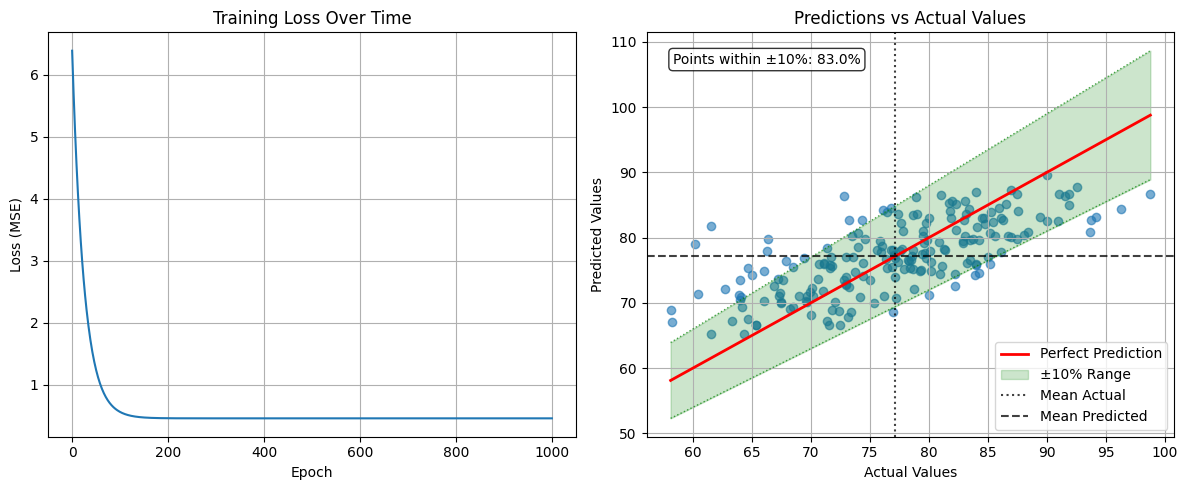

In [18]:
## Visualize results
plt.figure(figsize=(12, 5))

## Training loss over epochs
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)

## Predictions vs Actual values
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)

## Perfect prediction
x_range = [y_test.min(), y_test.max()]
plt.plot(x_range, x_range, 'r-', lw=2, label='Perfect Prediction')

## ±10% from perfect prediction
# Fill between the ±10% lines
upper_line = [y_test.min()*1.1, y_test.max()*1.1]
lower_line = [y_test.min()*0.9, y_test.max()*0.9]
plt.fill_between(x_range, lower_line, upper_line, alpha=0.2, color='green', label='±10% Range')

# Add the ±10% lines
plt.plot(x_range, upper_line, 'g:', lw=1, alpha=0.7)
plt.plot(x_range, lower_line, 'g:', lw=1, alpha=0.7)

## Mean lines
plt.axvline(x=y_test.mean(), color='black', linestyle=':', alpha=0.75, label='Mean Actual')
plt.axhline(y=y_pred.mean(), color='black', linestyle='--', alpha=0.75, label='Mean Predicted')

## Count points within 10% range
within_10_percent = np.sum((y_pred >= 0.9 * y_test) & (y_pred <= 1.1 * y_test))
percentage_within_10_percent = (within_10_percent / len(y_test)) * 100

# Add text box with percentage
plt.text(
    0.05, 0.95, f'Points within ±10%: {percentage_within_10_percent:.1f}%', 
    transform=plt.gca().transAxes, verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

We can see that our loss quickly converged to some value close to around $200$ epochs, while our predicted values don't quite line up with many of the actual values. The red, solid line here shows where the predicted and actual values coincide. The green filled region shows where the predicted values are off by $10\%$ from the actual values, while the dotted and dashed black lines show the averages of the actual and predicted values. We seem to have quite a large scatter around the perfect prediction line, with many of the points falling outside the $10\%$ range. Finally, our predicted mean is a bit off compared to the actual mean. I think our model could benefit greatly from some improvements!

We've seen how much the features contribute to the predicted value through the weights, but let's visualize this with a bar chart.

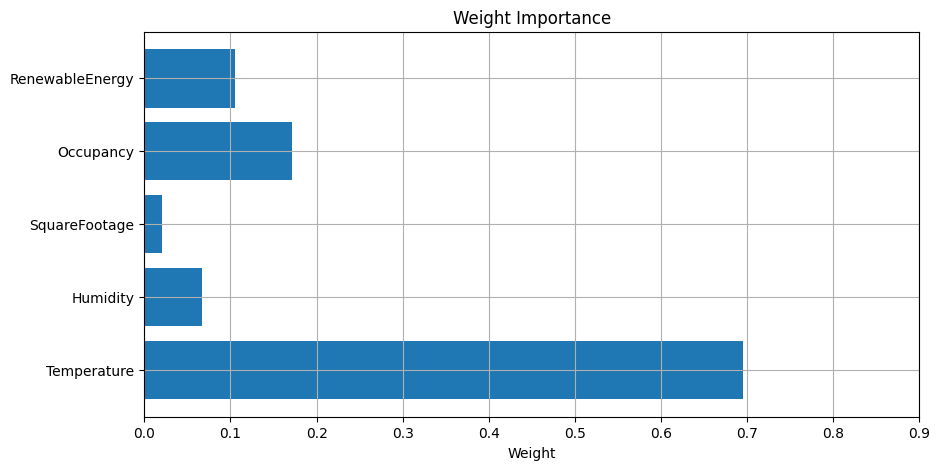

In [26]:
## Plot weight importance
feature_names = model.features
importance = torch.abs(model.weights).detach().numpy()

plt.figure(figsize=(10,5))
plt.barh(feature_names, importance)
plt.xticks(np.arange(round(min(importance)-0.1), round(max(importance)+0.1), 0.1))
plt.title("Weight Importance")
plt.xlabel("Weight")
plt.grid(True)
plt.show()

We can see the temperature has the most contribution to our predicted energy consumption, by far. In the next tutorial, we'll add in the rest of the features that we left out for this model, so we can see if any other features contribute nearly as much as the temperature. But, before we go adding other features, let's evaluate the ones we've already chosen a little bit more.  

We can check to see how much each of the features are *correlated* with each other and with the target. To do this we'll use the built in Pandas dataframe method to calculate the [Pearson correlation coefficient](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) $\left(r_{\alpha\beta}\right)$ between all features and the target. This measures the dependence of one variable on another. When the coefficient is equal to one $\left(r_{\alpha\beta}= 1\right)$, the two variables $\left(\alpha\right.$ and $\left.\beta\right)$ are perfectly, positively correlated - as one increases by some amount the other will *increase* by the same amount. When $r_{\alpha\beta}=- 1$, the two variables are perfectly, negatively correlated - as one increases by some amount the other will *decrease* by the same amount. And if $r_{\alpha\beta}=0$, the two variables are independent of each other - changing one variable has no effect on the other.

This correlation coefficient between the variables $\alpha$ and $\beta$ is given by:

$$
r_{\alpha\beta} = \frac{\sum_{i=1}^{n}(\alpha_i - \bar{\alpha})(\beta_i - \bar{\beta})}{\sqrt{\sum_{i=1}^{n}(\alpha_i - \bar{\alpha})^2 \sum_{i=1}^{n}(\beta_i - \bar{\beta})^2}}
$$
where $\alpha_i$ and $\beta_i$ are the $i$-th values and $\bar{\alpha}$ and $\bar{\beta}$ are the averages of $\alpha$ and $\beta$.

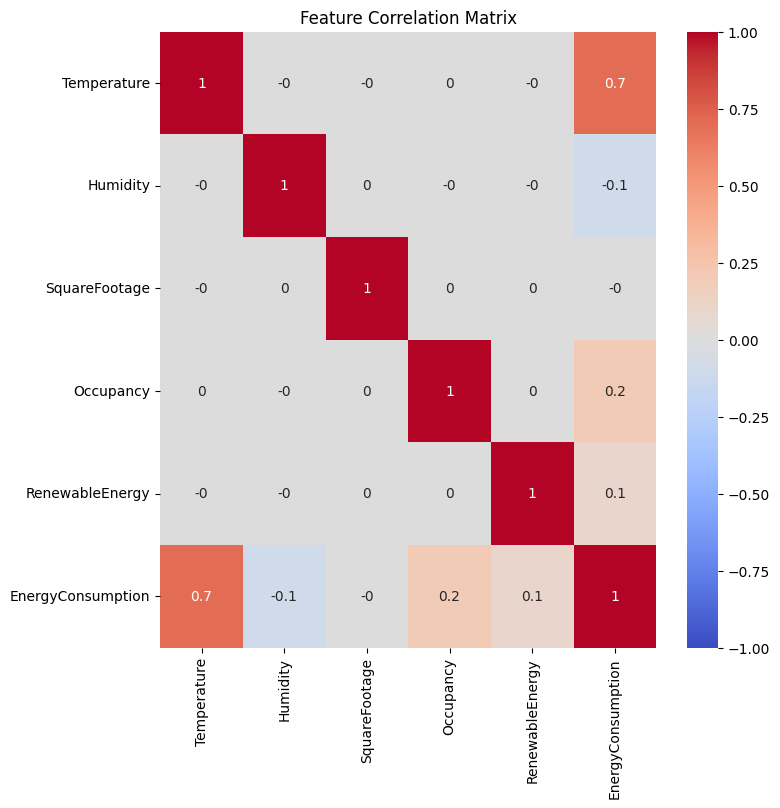

In [25]:
## Create dataframe from processed training data
df = pd.DataFrame(X_train_scaled, columns=model.features)
df['EnergyConsumption'] = y_train_scaled

## Calculate correlation matrix
corr_matrix = df.corr()

## Plot correlation matrix
# Notice we're rounding correlation coefficients to nearest decimal
plt.figure(figsize=(8, 8))
sns.heatmap(round(corr_matrix, 1), annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()

We can see that the temperature and total energy consumed are highly, positively correlated, while the occupancy and renewable energy sources are somewhat, positively correlated with the target. The humidity has the most negative correlation with the target while none of the features seem to be too dependent on each other. 

It seems that perhaps we can get rid of the `SquareFootage` feature as it has little correlation with the target or other features. But, let's checkout the [permutation importance](https://www.kaggle.com/code/dansbecker/permutation-importance) for each of the features to confirm our suspicion. This will be another measure of how important the feature is to predicting the target. How does it work?

First, we calculate the [MSE](#loss-function) for predictions made with the test set, this will be our reference point. Then, for each feature, we shuffle all the values around while keeping all other features the same. Finally, we calculate the MSE for this set of features and compare it to our baseline MSE. When predictions of the target depend heavily on a feature, shuffling its values should cause the model to make much worse predictions. These sorts of features will give large, *positive* permutation importances. On the other hand, if a feature has no effect on predictions, shuffling the values shouldn't really change the predictions very much, resulting in small, positive or negative importances. Finally, if including a feature causes a model to make significantly worse predictions, shuffling its values should give us a large, *negative* permutation importance.

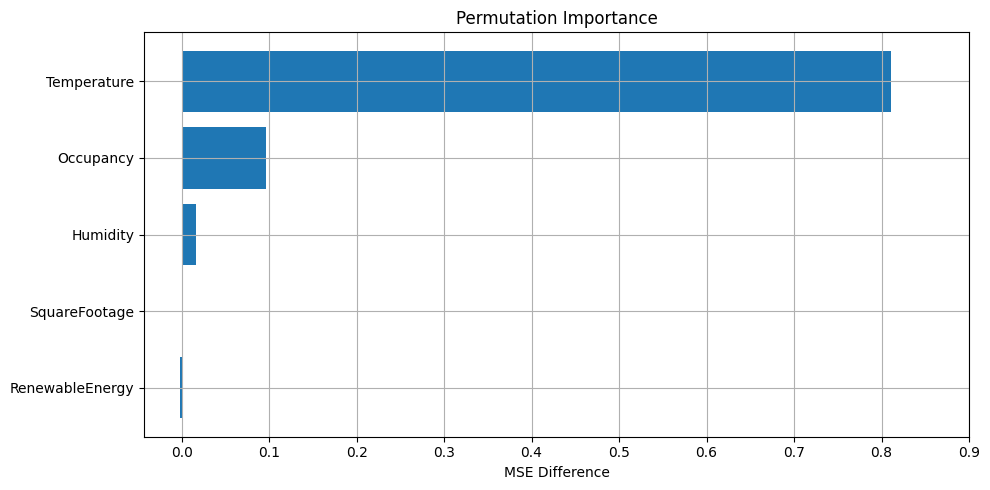

In [23]:
## Calculate the MSE for predictions on the test set
baseline_pred = model.forward(torch.FloatTensor(X_test_scaled)).detach().numpy()
baseline_mse = mean_squared_error(y_test_scaled, baseline_pred)

## Loop through each feature
importance_scores = []
for i in range(X_test_scaled.shape[1]):
    # Copy the test data and shuffle the values for the feature
    X_permuted = X_test_scaled.copy()
    np.random.shuffle(X_permuted[:, i])
    
    # Calculate the MSE for predictions with this new set of features
    permuted_pred = model.forward(torch.FloatTensor(X_permuted)).detach().numpy()
    permuted_mse = mean_squared_error(y_test_scaled, permuted_pred)

    # Importance is difference b/w MSE values
    importance = permuted_mse - baseline_mse
    importance_scores.append(importance)

# Create feature importance dictionary and sort values by importance
feature_importance = dict(zip(model.features, importance_scores))
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Extract feature names and importance scores
features, importances = zip(*sorted_features)

# Create horizontal bar chart
plt.figure(figsize=(10, 5))
bars = plt.barh(range(len(features)), importances)
plt.xticks(np.arange(round(min(importances)-0.1), round(max(importances)+0.1), 0.1))
plt.yticks(range(len(features)), features)
plt.xlabel('MSE Difference')
plt.title('Permutation Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(True)
plt.show()

We can see that the `Humidity`, `RenewableEnergy` , and `SquareFootage` features tend to have a small effect on predictions, as shuffling their values doesn't change the MSE that much. The temperature has a huge effect on predictions, while the occupancy has a mild effect. To make our model simpler, we can potentially drop the features that seem to have little effect (i.e. little weight and permutation importance with small correlation coefficients across the board). However, we still have quite a number of features that we left out. Perhaps some of the features that show little importance or correlation will change once we look at the entire feature set. 

We've briefly gone over supervised learning and started examining learning methods with a very simple one, the linear regression model. We saw how to create data from a Kaggle dataset and how to scale it and split it for better performance. We also saw how to setup a linear regression model and how to train it on our training set. Finally, we saw how to evaluate our model after training through metrics and plots. 

We did all this through a step-by-step guide on how to create and train a model from start to finish, and we also saw a little bit of the supporting math throughout our journey. 

Stay tuned for the next tutorial, where we'll add the rest of the features that we left out. Do you think it will improve our model? What other features do you think could have a strong contribution to energy consumption?